In [2]:
import numpy as np

In [3]:
import os

In [4]:
import ntpath

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as col

In [6]:
from power_spec import power_spec as ps

In [7]:
from cpw_resonator import cpw_resonator as cpw

In [8]:
from qkit.analysis.resonator import Resonator as Resonator

In [9]:
from qkit.analysis import dat_reader as dat

In [10]:
from qkit.analysis.circle_fit.utilities import plotting, save_load, Watt2dBm, dBm2Watt

In [11]:
from qkit.analysis.circle_fit.circuit import reflection_singleport as rf_p

In [12]:
from qkit.analysis.circle_fit.circuit import reflection_port as rf

In [13]:
%matplotlib inline

In [14]:
from qkit.storage import hdf_lib

In [15]:
import random

In [16]:
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage.filters import median_filter

In [17]:
font = {'weight' : 'normal', 'size' : 22}
plt.rc('font', **font)
labelsize=30

In [18]:
import scipy.special as ss
import scipy.constants as sc


phi_0 = sc.physical_constants['magn. flux quantum'][0]
c = sc.physical_constants['speed of light in vacuum'][0]   
h = sc.h
hbar = sc.h/(2*np.pi)
e = sc.e 
R_k = h/e**2

# resonator parameters: 

In [19]:
cpw_res = cpw(20e-6, 12e-6, 2850e-6, 12e-15)

In [20]:
cpw_res.get_values()

Ll = 4.38459342705e-07 H/m
Cl = 1.63570516377e-10 F/m
distributed:
L = 1.24960912671e-09 H
C = 4.66175971675e-13 F
R = 0.234241557505 Ohm
lumped element:
Lr = 1.01289500647e-09 H
Cr = 2.33087985838e-13 F
Rr = 14979288.7616 Ohm

Q_int = 117647.058824 
Q_ext = 537.08862226 
Q_load = 534.647819543 

f_res = 10358049260.0 GHz
f_resc = 10101668046.9 GHz 


In [21]:
2.*np.pi*cpw_res._fresc/(cpw_res._Qext*10**6)

118.17538041124944

In [22]:
alpha_0 = np.pi**2.*cpw_res._wresc*50/R_k

In [23]:
    def _set_data_range(freq,data, f_min, f_max):
        '''
        cuts the data array to the positions where f>=f_min and f<=f_max in the frequency-array
        the fit functions are fitted only in this area
        the data in the .h5-file is NOT changed
        '''
        ret_array = []
        if data.ndim == 1:
            return data[(freq >= f_min) & (freq <= f_max)]
        if data.ndim == 2:
            fit_freq = freq[(freq >= f_min) & (freq <= f_max)]
            ret_array=np.empty(shape=(data.shape[0],fit_freq.shape[0]),dtype=np.float64)
            for i,a in enumerate(data):
                ret_array[i]=data[i][(freq >= f_min) & (freq <= f_max)]
            return ret_array
            
    def _prepare_f_range(freq,f_min,f_max, array):
        '''
        prepares the data to be fitted:
        f_min (float): lower boundary
        f_max (float): upper boundary
        '''

        ff_min = np.min(freq)
        ff_max = np.max(freq)

        '''
        f_min f_max do not have to be exactly an entry in the freq-array
        '''
        if f_min:
            for freq_1 in freq:
                if freq_1 > f_min:
                    ff_min = freq_1
                    break
        if f_max:
            for freq_1 in freq:
                if freq_1 > f_max:
                    ff_max = freq_1
                    break
                    
        return np.array(_set_data_range(freq,array, ff_min, ff_max))


In [24]:
powerpath = "C:/Users/Patrick/Documents/JPA/Ivan/20160728/092323_2D_power_sepc_-30_to0_step0.25/092323_2D_power_sepc_-30_to0_step0.25.h5"
#powerpath = "C:/Users/Patrick/Documents/JPA/Mask #3/data/20160407/115511_2D_VNA_tracedata/115511_2D_VNA_tracedata.h5"
#powerpath = "C:/Users/Patrick/Documents/JPA/Mask #3/data/20160407/120624_2D_VNA_tracedata/120624_2D_VNA_tracedata.h5"

In [25]:
data=hdf_lib.Data(path=powerpath)

In [26]:
#filename_ext = os.path.basename(powerpath)

In [27]:
#filename = os.path.splitext(filename_ext)[0]

In [28]:
freq = np.array(data['/entry/data0/frequency'])
amp = np.array(data['/entry/data0/amplitude'])
power = np.array(data['/entry/data0/power (dbm)'])
phase = np.array(data['/entry/data0/phase'])

In [29]:
z_data_raw = amp*np.exp(1.j*phase)

In [30]:
f_min = freq[200]
f_max = freq[-200]
print f_min, f_max

7390000000.0 7630150000.0


In [31]:
fit_freq = _prepare_f_range(freq, f_min, f_max, freq)

# data range

In [32]:
fit_amp = []
fit_amp = _prepare_f_range(freq, f_min, f_max, amp)

In [33]:
fit_phase = []
fit_phase = _prepare_f_range(freq, f_min, f_max, phase)

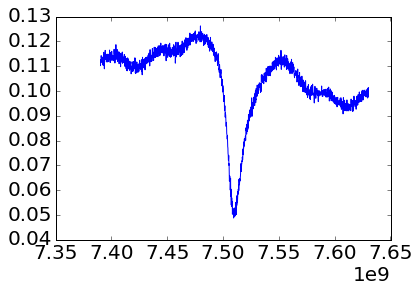

In [34]:
plt.plot(fit_freq, fit_amp[0])

In [35]:
fit_z_data_raw = fit_amp*np.exp(1.j*fit_phase)

In [36]:
cf = rf_p(fit_freq, fit_z_data_raw[0])

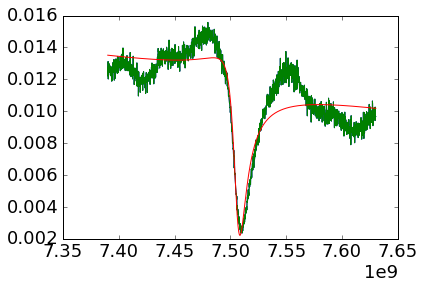

In [37]:
i = 10
A1, A2, A3, A4, fr, Ql = cf._fit_skewed_lorentzian(fit_freq, fit_z_data_raw[i], ignoreslope=True)
lorentzian = (A1+A2*(fit_freq-fr)+(A3+A4*(fit_freq-fr))/(1.+4.*Ql**2*((fit_freq-fr)/fr)**2))
plt.plot(fit_freq, fit_amp[i]**2.)
plt.plot(fit_freq, np.absolute(fit_z_data_raw[i])**2.)
plt.plot(fit_freq, lorentzian)

In [38]:
amp.shape

(120, 2001)

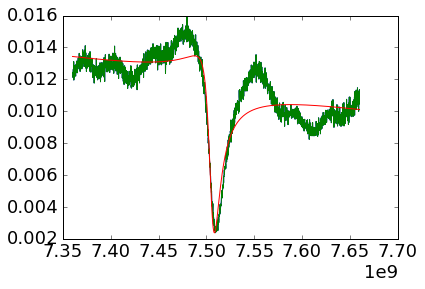

In [39]:
i = 0
A1, A2, A3, A4, fr, Ql = cf._fit_skewed_lorentzian(freq, z_data_raw[i], ignoreslope=True)
lorentzian = (A1+A2*(freq-fr)+(A3+A4*(freq-fr))/(1.+4.*Ql**2*((freq-fr)/fr)**2))
plt.plot(freq, amp[i]**2.)
plt.plot(freq, np.absolute(z_data_raw[i])**2.)
plt.plot(freq, lorentzian)

# Circle fit

In [40]:
cf.set_theta0(-4)

C:\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 200.
  warnings.warn(errors[info][0], RuntimeWarning)


fr (phase derivation) = 7507600000.0
get delay
theta_0 = -4.48232767156, fr = 7506921896.14, Ql = 521.387140974, sign = 1.0, slope = -3.51920522848e-10


(2.9851362678616736e-09,
 [0.011817268641855144,
  -8.8160025268179413e-12,
  -0.0079122432565672425,
  -1.1044093220261311e-09,
  7506921896.1442099,
  521.3871409738689])

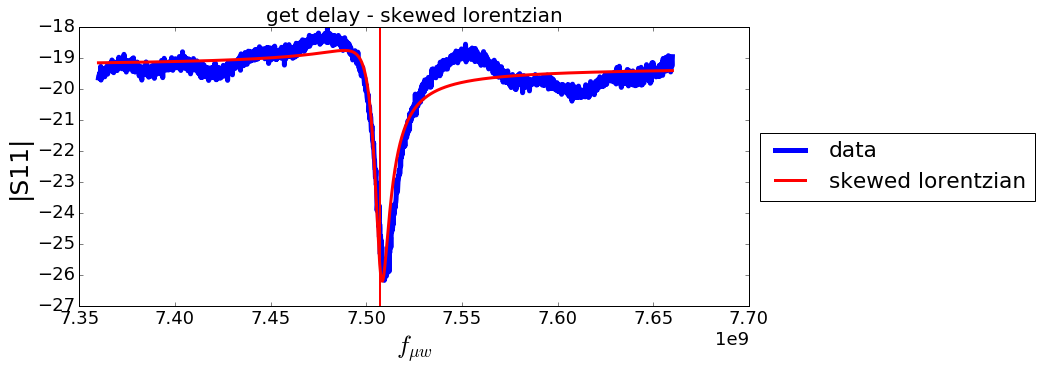

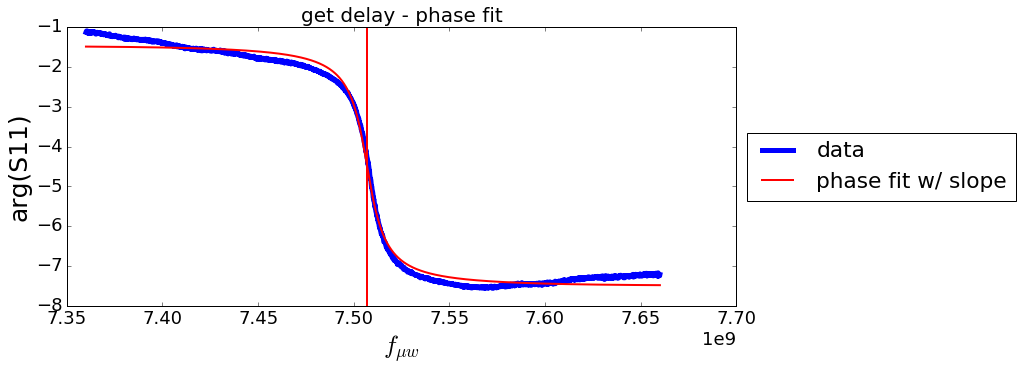

In [41]:
cf.get_delay(freq, z_data_raw[0], coupling = 'overcoupled', plot = True)

In [42]:
cf.autofit(coupling = 'overcoupled', ignoreslope = False, plot = False)

C:\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(errors[info][0], RuntimeWarning)


fr (phase derivation) = 7507300000.0
agebraic r0: 0.0928552496955
iterative r0: 0.0923876999318
zc = (-0.011363009936-0.0266088379882j)
calibration: Theta0 -4.38052657566
agebraic r0: 0.735716088491
iterative r0: 0.737937092355
-2.94851251548
phi_0 = 0.193080138108


C:\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [43]:
cf.fitresults

{'Qc': 532.54897867945419,
 'Qc_err': 24.690834040772252,
 'Qi': 1499.5927824928222,
 'Qi_err': 293.5364479021103,
 'Ql': 392.98764486338945,
 'Ql_err': 6.8066816697166272,
 'chi_square': 0.016238204590995058,
 'fr': 7505471088.3713236,
 'fr_err': 174513.93618065523,
 'phi_0': 0.19308013810762611,
 'phi_0_err': 0.017908373105973756,
 'theta0': -2.9460775542862763}

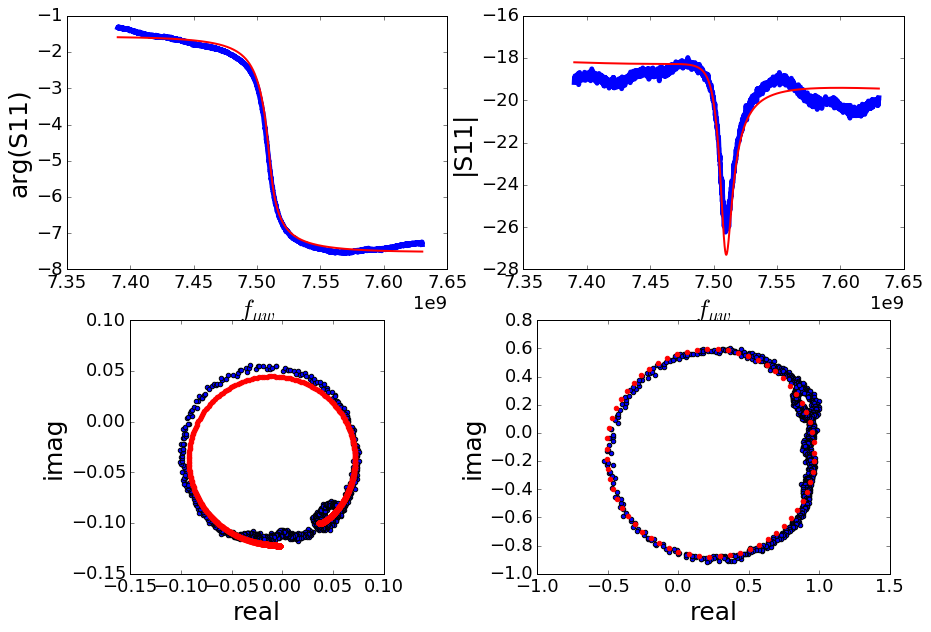

In [44]:
cf.plot_all()

# amplitude and phase signal

In [45]:
i = 0

In [46]:
lorentz_sim = cf.Lorentz_function(freq, A1, A2, A3, A4, Ql, fr)

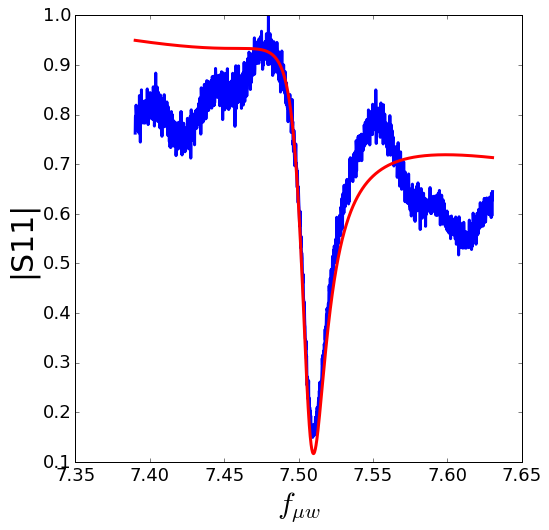

In [47]:
amp = np.absolute(fit_z_data_raw[i])
fig_amp, axes = plt.subplots(figsize = (8,8))
axes.plot(fit_freq/10**9., amp**2./np.max(amp**2.), label = 'data', lw = 3.)
#axes.plot(freq/10**9., lorentz_sim/np.max(amp**2.),label = 'skewed lorentzian', color = 'red', lw = 3.)
axes.plot(fit_freq/10**9., np.absolute(cf.z_data_sim)**2./np.max(amp**2.),label = 'skewed lorentzian', color = 'red', lw = 3.)
axes.set_xlabel(r'$f_{\mu w}$', fontsize = labelsize)
axes.set_ylabel(r'|S11|', fontsize = labelsize)
#axes.set_xlim(8.83,8.85)
#axes.set_yticks([0.84,0.88, 0.92, 0.96, 1.0])

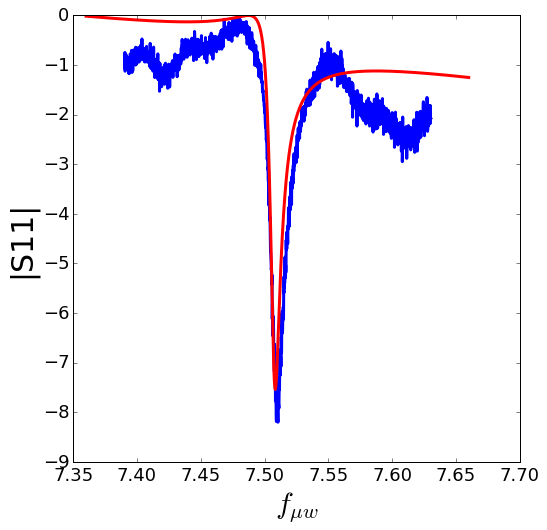

In [48]:
amp = np.absolute(fit_z_data_raw[10])
fig_amp, axes = plt.subplots(figsize = (8,8))
axes.plot(fit_freq/10**9., 10*np.log10(amp**2./np.max(amp**2.)), label = 'data', lw = 3.)
axes.plot(freq/10**9., 10*np.log10(lorentz_sim/np.max(lorentz_sim)),label = 'skewed lorentzian', color = 'red', lw = 3.)
#axes.plot(fit_freq/10**9., np.log10(np.absolute(cf.z_data_sim)**2./np.max(amp**2.)),label = 'skewed lorentzian', color = 'red', lw = 3.)
axes.set_xlabel(r'$f_{\mu w}$', fontsize = labelsize)
axes.set_ylabel(r'|S11|', fontsize = labelsize)
#axes.set_xlim(8.83,8.85)
#axes.set_yticks([0.84,0.88, 0.92, 0.96, 1.0])

(7.3901500000000002, 7.6303000000000001)

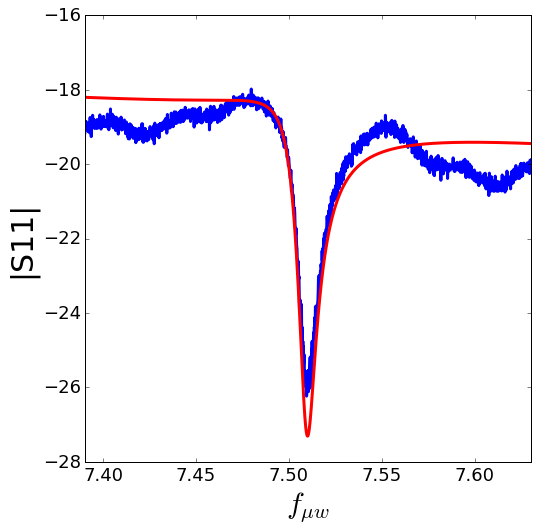

In [49]:
amp = np.absolute(fit_z_data_raw[i])
fig_amp, axes = plt.subplots(figsize = (8,8))
axes.plot(fit_freq/10**9., 10*np.log10(amp**2.), label = 'data', lw = 3.)
#axes.plot(freq/10**9., lorentz_sim/np.max(amp**2.),label = 'skewed lorentzian', color = 'red', lw = 3.)
axes.plot(fit_freq/10**9., 10*np.log10(np.absolute(cf.z_data_sim)**2.),label = 'skewed lorentzian', color = 'red', lw = 3.)
axes.set_xlabel(r'$f_{\mu w}$', fontsize = labelsize)
axes.set_ylabel(r'|S11|', fontsize = labelsize)
axes.set_xlim(fit_freq[0]/10**9.,fit_freq[-1]/10**9.)
#axes.set_yticks([0.84,0.88, 0.92, 0.96, 1.0])

(7.3901500000000002, 7.6303000000000001)

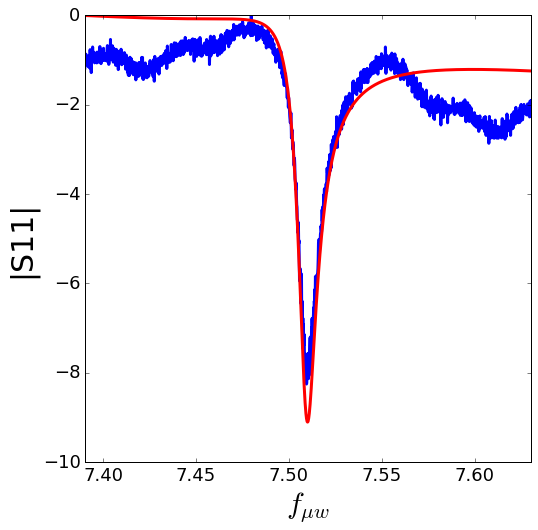

In [50]:
amp = np.absolute(fit_z_data_raw[i])
fig_amp, axes = plt.subplots(figsize = (8,8))
axes.plot(fit_freq/10**9., 10*np.log10(amp**2./np.max(amp**2.)), label = 'data', lw = 3.)
#axes.plot(freq/10**9., lorentz_sim/np.max(amp**2.),label = 'skewed lorentzian', color = 'red', lw = 3.)
axes.plot(fit_freq/10**9., 10*np.log10(np.absolute(cf.z_data_sim)**2./np.max(np.absolute(cf.z_data_sim)**2.)),label = 'skewed lorentzian', color = 'red', lw = 3.)
axes.set_xlabel(r'$f_{\mu w}$', fontsize = labelsize)
axes.set_ylabel(r'|S11|', fontsize = labelsize)
axes.set_xlim(fit_freq[0]/10**9.,fit_freq[-1]/10**9.)
#axes.set_yticks([0.84,0.88, 0.92, 0.96, 1.0])

In [51]:
fig_amp.savefig('Ivan_amp_low_P.pdf', dpi = 400, bbox_inches = 'tight')

In [52]:
fr, sign = cf._phase_fr_sign(freq, np.unwrap(np.angle(z_data_raw[i])), 3, 20)
theta0 = cf._theta0_start(freq,np.unwrap(np.angle(z_data_raw[i])), fr)
theta0, Ql, fr, slope = cf._phase_fit_wslope(freq, z_data_raw[i], -4, 1100, fr, 0.,1, overcoupled = True)
  

fr (phase derivation) = 7507600000.0


In [53]:
theta0

-4.482327670548262

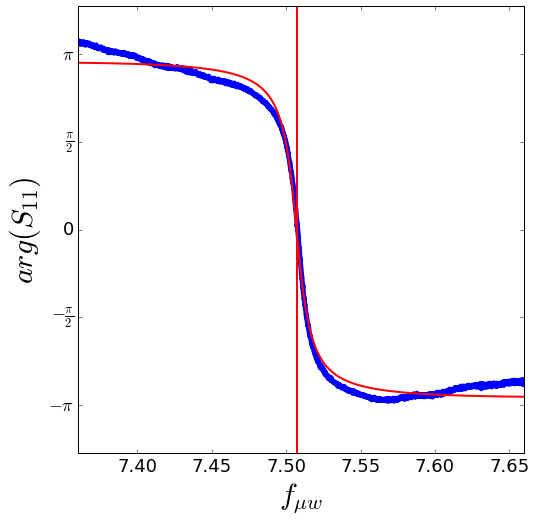

In [54]:
phase = np.unwrap(np.angle(z_data_raw[i]))-theta0
phase_fit = cf.phase_fitfunction(freq, theta0, Ql, fr, slope, 1., True)[0]-theta0
fig, axes = plt.subplots(figsize = (8,8))
axes.plot(freq/10**9, phase, label = 'data', lw = 5.)
axes.plot(freq/10**9., phase_fit,label = 'phase fit w/ slope', color = 'red', lw = 2.)
axes.axvline(fr/10**9., color = 'red', ls = '-', lw = 2.)
axes.set_xlabel(r'$f_{\mu w}$', fontsize = labelsize)
axes.set_ylabel(r'$arg(S_{11})$', fontsize = labelsize)
axes.set_xlim(freq[0]/10**9.,freq[-1]/10**9.)
plt.setp(axes, yticks=[-np.pi,-np.pi/2, 0., np.pi/2., np.pi], yticklabels = [r'$-\pi$',r'$-\frac{\pi}{2}$', '0',  r'$\frac{\pi}{2}$', r'$\pi$'])
#axes.set_title(str(title), fontsize = 20.)
#axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [55]:
fig.savefig('Ivan_phase_low_P.pdf', dpi = 400, bbox_inches = 'tight')

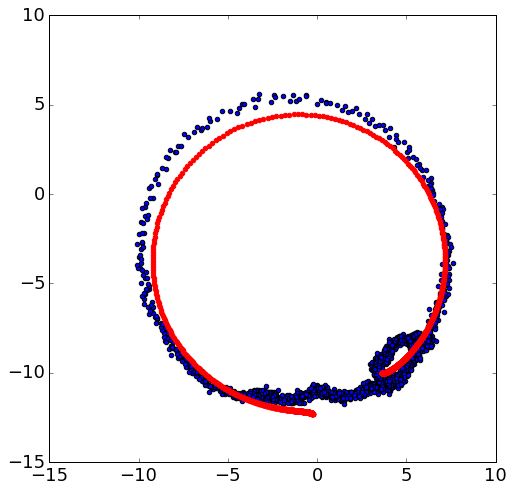

In [56]:
fig_comp = plt.figure(figsize = (8,8))
plt.scatter(z_data_raw[0].real*100, z_data_raw[0].imag*100)
plt.scatter(cf.z_data_sim.real*100, cf.z_data_sim.imag*100, color = 'red')
#plt.xlim(-0.2, 0.2)
#plt.ylim(-0.2, 0.2)
#plt.xticks([-0.2,-0.1,0,0.1,0.2])
#plt.yticks([-0.2,-0.1,0,0.1,0.2])


#  frequency shift

In [64]:
_fr = []
_Ql = []
_Ql_cf = []

In [65]:
for c in range(len(power)):
    A1, A2, A3, A4, fr, Ql = cf._fit_skewed_lorentzian(freq, z_data_raw[c], ignoreslope=True)
    cf = rf_p(freq, z_data_raw[c])
    cf.autofit('overcoupled')
    _fr.append(fr)
    _Ql.append(Ql)
    _Ql_cf.append(cf.fitresults['Ql'])

fr (phase derivation) = 7507600000.0
agebraic r0: 0.0858257214915
iterative r0: 0.085081313972
zc = (-0.0134907318731-0.0304490876565j)
calibration: Theta0 -4.22884490924
agebraic r0: 0.775307844428
iterative r0: 0.780988304403
-2.8996691638
phi_0 = 0.241923489785
fr (phase derivation) = 7507600000.0
agebraic r0: 0.0857968772177
iterative r0: 0.0850535829401
zc = (-0.0134342417105-0.0304904763995j)
calibration: Theta0 -4.22932017413
agebraic r0: 0.774863757914
iterative r0: 0.780473466149
-2.90012616158
phi_0 = 0.241466492008
fr (phase derivation) = 7507600000.0
agebraic r0: 0.085786458255
iterative r0: 0.0850427589666
zc = (-0.0133834132683-0.0304379587023j)
calibration: Theta0 -4.22986873109
agebraic r0: 0.774952515486
iterative r0: 0.780644125741
-2.9008027089
phi_0 = 0.240789944694
fr (phase derivation) = 7507600000.0
agebraic r0: 0.0858072211201
iterative r0: 0.0850645143139
zc = (-0.0134741578446-0.0304609506706j)
calibration: Theta0 -4.2294527761
agebraic r0: 0.775053993812
iter

C:\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


calibration: Theta0 -3.96708699988
agebraic r0: 0.968397471692
iterative r0: 0.626684688841
-2.8582737128
phi_0 = 0.283318940795
fr (phase derivation) = 7455100000.0
agebraic r0: 0.0871804602123
iterative r0: 0.0568854813844
zc = (-0.0115819345428-0.0300340189102j)
calibration: Theta0 2.45167740265
agebraic r0: 1.18650737135
iterative r0: 0.771784949378
-2.71431929808
phi_0 = 0.427273355514
fr (phase derivation) = 7453600000.0
agebraic r0: 0.0855780729852
iterative r0: 0.0527752429398
zc = (-4.61588737588e-05-0.036949181866j)
calibration: Theta0 -3.82889631134
agebraic r0: 1.03033695984
iterative r0: 0.649633634451
-2.78787687721
phi_0 = 0.353715776377
fr (phase derivation) = 7451050000.0
agebraic r0: 0.0905306587502
iterative r0: 0.0823100447258
zc = (-0.0219094144143-0.0248459691259j)
calibration: Theta0 2.45109289581
agebraic r0: 1.02041542375
iterative r0: 0.938102641644
-2.75461135504
phi_0 = 0.386981298545
fr (phase derivation) = 7449100000.0
agebraic r0: 0.0895735859632
iterativ

C:\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


calibration: Theta0 2.49958868292
agebraic r0: 0.972028068859
iterative r0: 0.89657468033
-2.76654931155
phi_0 = 0.375043342036
fr (phase derivation) = 7445500000.0
agebraic r0: 0.0897341813586
iterative r0: 0.0866148395333
zc = (-0.0144850348632-0.0257782324796j)
calibration: Theta0 2.49257504003
agebraic r0: 0.923327907909
iterative r0: 0.909137339386
-2.82907470313
phi_0 = 0.312517950463
fr (phase derivation) = 7447300000.0
agebraic r0: 0.0891216808796
iterative r0: 0.0868788268018
zc = (-0.0163137170006-0.0257112148709j)
calibration: Theta0 2.46520759068
agebraic r0: 0.903268869725
iterative r0: 0.912647746335
-2.81806232522
phi_0 = 0.323530328373
fr (phase derivation) = 7444750000.0
agebraic r0: 0.0892505193369
iterative r0: 0.0869149085896
zc = (-0.016802958751-0.0254301823913j)
calibration: Theta0 2.49087519543
agebraic r0: 0.914076860654
iterative r0: 0.924508496921
-2.81215013449
phi_0 = 0.329442519097
fr (phase derivation) = 7441900000.0
agebraic r0: 0.0910317692676
iterative

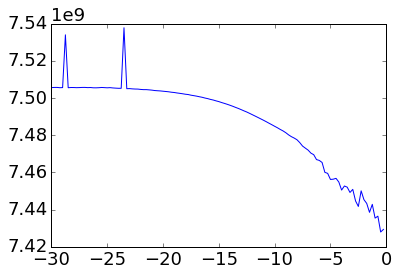

In [66]:
plt.plot(power, _fr)

(0, 1000)

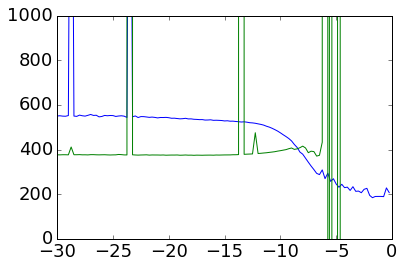

In [69]:
plt.plot(power, _Ql)
plt.plot(power, _Ql_cf)
plt.ylim(0,1000)

In [181]:
_fr = np.array(_fr)
fres_mask = []
mask = []
for i in range(len(_fr)):
    low = 7.00e9
    high = 7.52e9
    mask.append(np.any((_fr[i] > high, _fr[i] < low), axis = 0))
fres_mask = np.ma.masked_array(_fr,mask)

In [182]:
np.ma.masked_array

numpy.ma.core.MaskedArray

In [183]:
fres_mask[5]=fres_mask[4]

In [184]:
fres_mask[26] = fres_mask[25]

In [185]:
z = np.where(fres_mask == False)[0]

In [186]:
z

array([], dtype=int32)

In [42]:
fres_mask[26]= fres_mask[25]

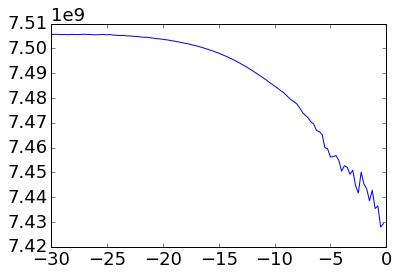

In [43]:
plt.plot(power, fres_mask)

In [152]:
cf2 = rf_p(freq, z_data_raw[0])

In [153]:
cf2.autofit(coupling = 'overcoupled', ignoreslope = False, plot = False)

fr (phase derivation) = 7507600000.0
agebraic r0: 0.0935650947103
iterative r0: 0.0930478612409
zc = (-0.010245918671-0.026636534568j)
calibration: Theta0 -4.29875761441
agebraic r0: 0.741232290372
iterative r0: 0.744866126729
-2.94068435434
phi_0 = 0.200908299253


In [154]:
cf2.fitresults

{'Qc': 516.04675715469648,
 'Qc_err': 31.36482406016707,
 'Qi': 1506.6041379936009,
 'Qi_err': 399.04610175103909,
 'Ql': 384.3857492127633,
 'Ql_err': 8.6930932674546444,
 'chi_square': 0.02887370626486006,
 'fr': 7504717233.3218355,
 'fr_err': 230402.1992582434,
 'phi_0': 0.20090829925308359,
 'phi_0_err': 0.023471858778515205,
 'theta0': -2.9384514093868055}

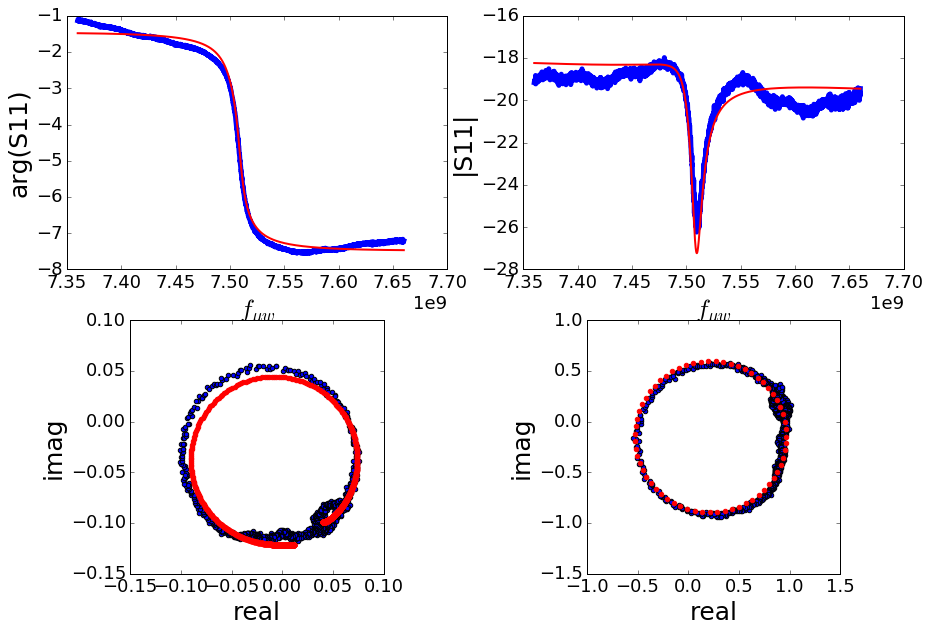

In [155]:
cf2.plot_all()

# power sweep

In [51]:
powerspec = ps(powerpath, gaussfilter = False)

no change - attenuation already: 0 dB


In [52]:
attenuation = 110

In [53]:
powerspec._set_attenuation(attenuation)

In [54]:
#powerspec2._set_gauss_nmb(10.)
#powerspec2._prep_data(gaussfilter = False)

In [55]:
#powerspec._get_window()

In [56]:
#powerspec._set_window(True)

In [87]:
powerspec._set_figsize(10,7)

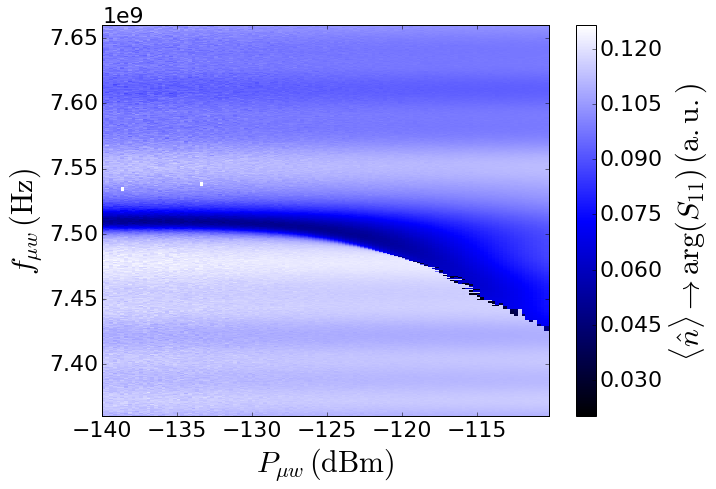

In [88]:
powerspec._plot_amp(norm = False, save = False)

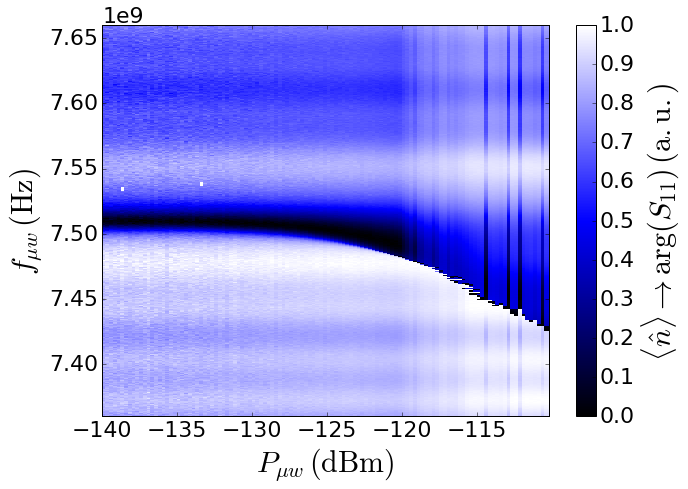

In [89]:
powerspec._plot_amp(norm = True, save = False)

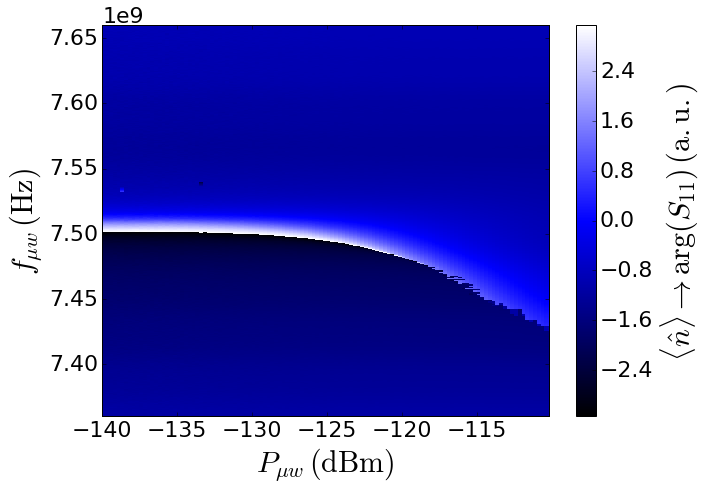

In [90]:
powerspec._plot_phase(norm = False, save = False)
#powerspec2._plot_phase(norm = True, save = False)

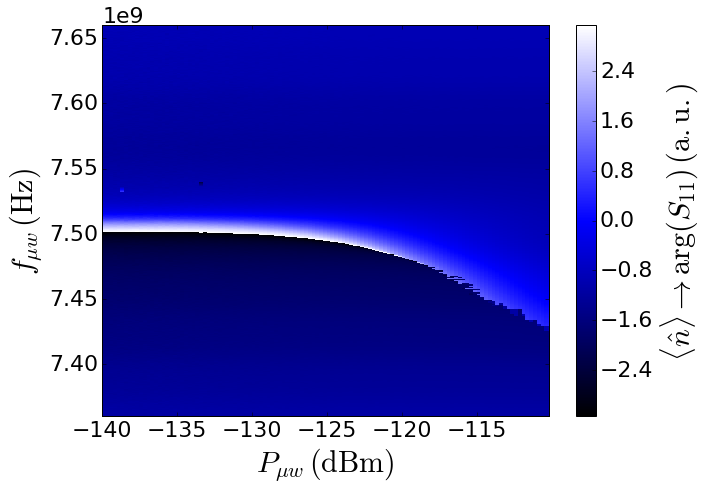

In [105]:
powerspec.plot(powerspec._power, powerspec._freq, powerspec._phase_spec)

In [106]:
powerspec._fig.savefig('Ivan_bifurcation_2D_no_fr.png', dpi = 400, bbox_inches = 'tight')

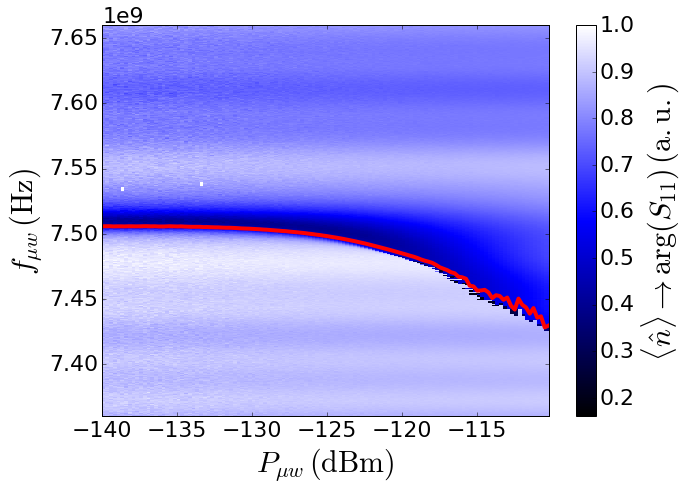

In [107]:
powerspec.plot(powerspec._power, powerspec._freq, powerspec._amp_spec/np.max(powerspec._amp_spec), fres_mask)

In [108]:
powerspec._fig.savefig('Ivan_bifurcation_2D_amp_norm.png', dpi = 400, bbox_inches = 'tight')
#powerspec._fig.savefig('Ivan_bifurcation_2D_amp_norm.pdf', dpi = 200, bbox_inches = 'tight')

In [93]:
amp_mask = powerspec.data_mask(1.0, amp)

In [94]:
amp.shape

(120, 2001)

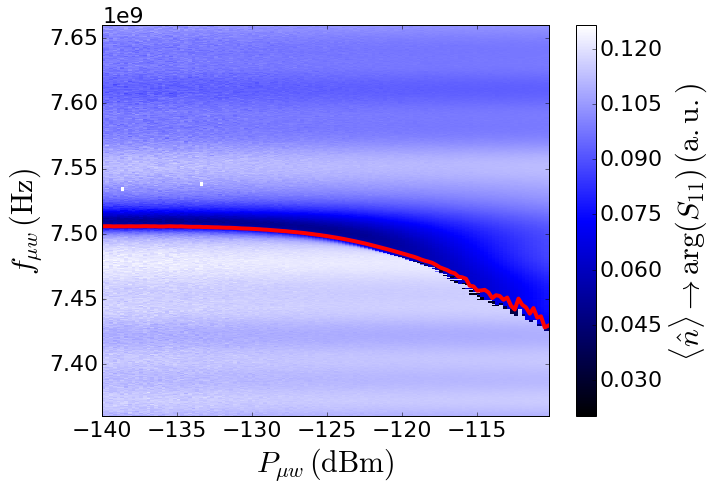

In [95]:
powerspec.plot(powerspec._power, freq, np.ma.masked_array( amp.T, amp_mask), fres_mask)

# Nonlinearity

In [109]:
power.shape

(120,)

In [201]:
P_crit = powerspec._power[76]

In [255]:
Qc = cf.fitresults['Qc']
Qi = cf.fitresults['Qi']
Ql = cf.fitresults['Ql']
fr = cf.fitresults['fr']
w0 = 2.*np.pi*fr

In [494]:
Cc_real = 1/np.sqrt(Qc*fr*50*2*np.pi/(cpw_res._Cr))

In [495]:
Cc_real

1.3623047830275396e-14

In [477]:
kappa = w0/Qc
gamma = w0/Qi
print kappa/10**6., gamma/10**6.

88.5519784168 31.44738106


In [203]:
P_c_watt = dBm2Watt(P_crit)

In [284]:
K = (kappa+gamma)**3.*hbar*w0/(P_c_watt*np.sqrt(27)*kappa)
print K

23512056.2275


In [207]:
K/(w0*10**(-6))

498.57762781224096

In [285]:
deltaf = -4*kappa*K*dBm2Watt(powerspec._power)/(2.*np.pi*(kappa+gamma)**2.*hbar*w0)

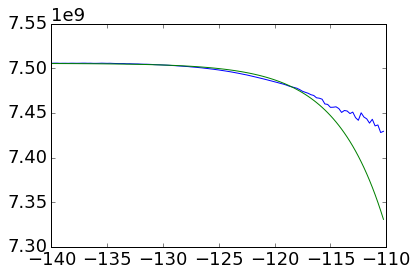

In [286]:
plt.plot(powerspec._power, fres_mask)
plt.plot(powerspec._power, fr+deltaf)

(7450000000.0, 7600000000.0)

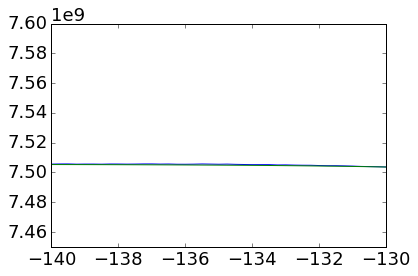

In [287]:
plt.plot(powerspec._power, fres_mask)
plt.plot(powerspec._power, fr+deltaf)
plt.xlim(-140,-130)
plt.ylim(7.45e9, 7.6e9)

# bifurcation

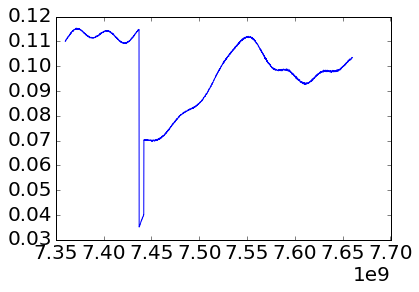

In [539]:
plt.plot(freq, amp[110] )

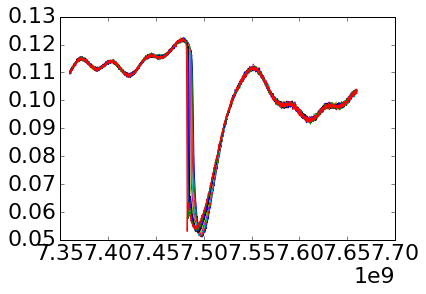

In [119]:
for i in range(10):
    plt.plot(freq, amp[70+i] )

In [131]:
color = cm.rainbow(np.linspace(0,1,10))

(7405000000.0, 7615150000.0)

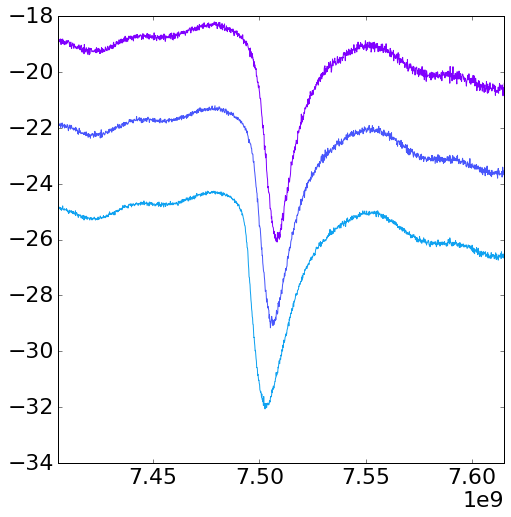

In [138]:
fig01 = plt.figure(figsize = (8,8))
for i in range(3):
    plt.plot(freq, 20.*np.log10(amp[40+i*10])-3*i, color = color[i])
plt.xlim(freq[300], freq[-300])

In [480]:
freq.shape

(2001,)

In [527]:
plt.legend?

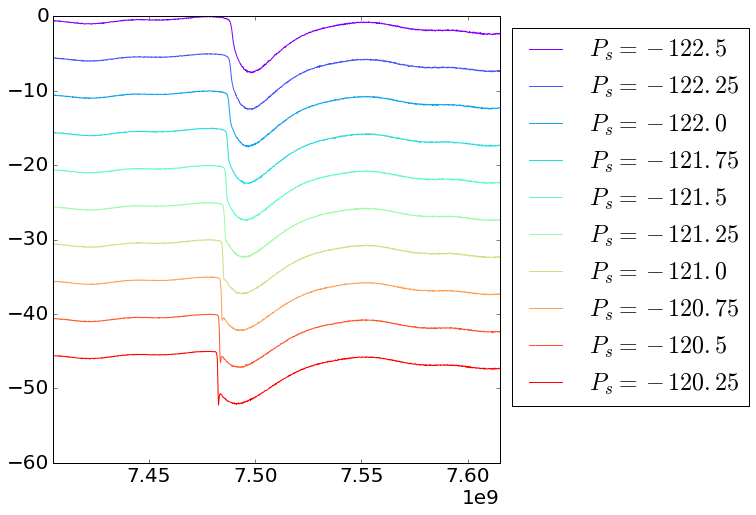

In [528]:
fig01 = plt.figure(figsize = (8,8))
for i in range(10):
    plt.plot(freq, 20.*np.log10(amp[70+i]/np.max(amp[70+i]))-5*i, label = r'$P_s = {}$'.format(str(powerspec._power[70+i])), color = color[i])
plt.xlim(freq[300], freq[-300])
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

In [529]:
fig01.savefig('bifurcation_amp_multi.pdf', dpi = 400, bbox_inches = 'tight')

(7360000000.0, 7660000000.0)

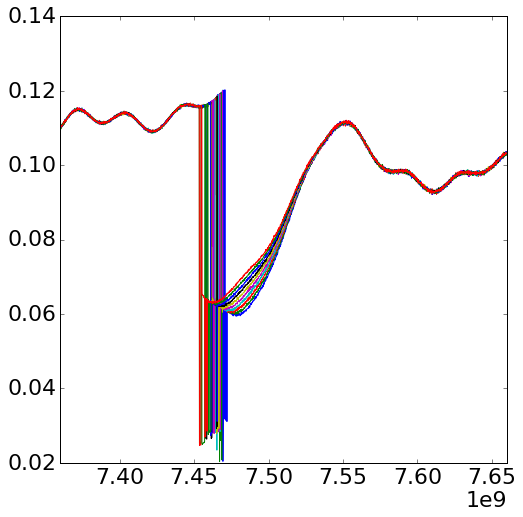

In [128]:
fig01 = plt.figure(figsize = (8,8))
for i in range(10):
    plt.plot(freq, amp[90+i])
plt.xlim(freq[0], freq[-1])

(7405000000.0, 7615150000.0)

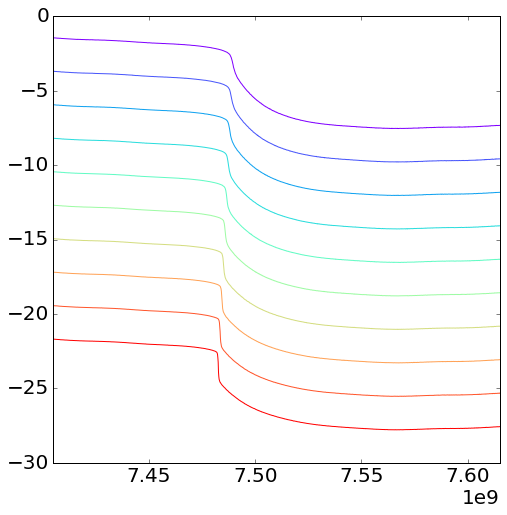

In [519]:
fig_phase02 = plt.figure(figsize = (8,8))
for i in range(10):
    plt.plot(freq, np.unwrap(phase[70+i])-2.25*i, color = color[i])
plt.xlim(freq[300], freq[-300])

In [520]:
fig_phase02.savefig('bifurcation_phase_multi.pdf', dpi = 400, bbox_inches = 'tight')

(7360000000.0, 7660000000.0)

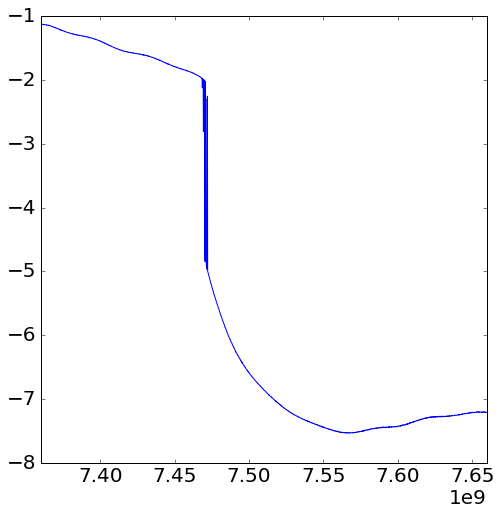

In [540]:
fig01 = plt.figure(figsize = (8,8))
for i in range(1):
    plt.plot(freq, np.unwrap(phase[90+i]), color = )
plt.xlim(freq[0], freq[-1])

In [567]:
ax1.set_yticklabels?

In [573]:
powerspec._power[78]

-120.5

(7405000000.0, 7615150000.0)

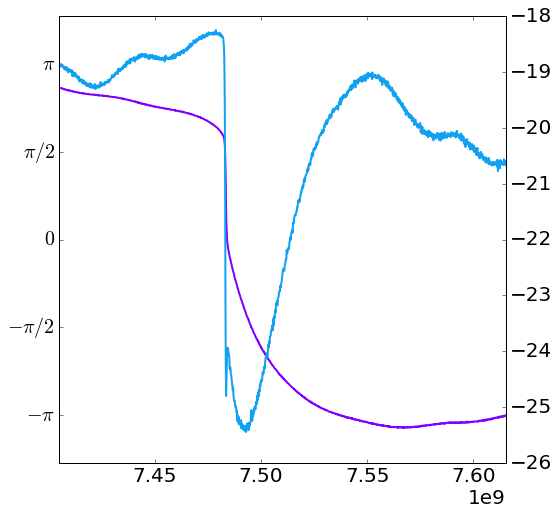

In [576]:
fig_comb, ax1 = plt.subplots(figsize = (8,8))
phase_plot = np.unwrap(phase[78])
ax1.plot(freq, phase_plot+np.abs(phase_plot[0]-phase_plot[-1])/2.-phase_plot[0], color = color[0], lw = 2. )
ax1.set_xlim(freq[300], freq[-300])
ax1.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax1.set_yticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$' ])
ax2 = ax1.twinx()
ax2.plot(freq, 20*np.log10(amp[78]), color = color[2], lw = 2.)
ax2.set_xlim(freq[300], freq[-300])


In [577]:
fig_comb.savefig('bifurcation_combined.pdf', dpi = 400, bbox_inches = 'tight')

In [66]:
_fr = np.array(_fr)
_fr_m = []
mask = []
for i in range(len(_fr)):
    low = _fr[0]-1e6
    high = 7.52e9
    mask.append(np.any((_fr[i] > high, _fr[i] < low), axis = 0))
_fr_m = np.ma.masked_array(_fr,mask)

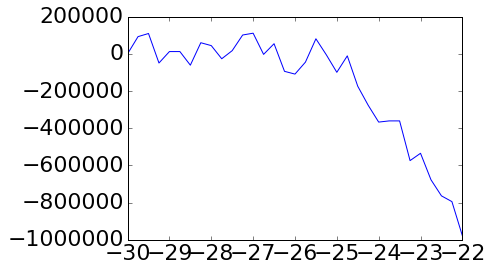

In [67]:
plt.plot(power, _fr_m-_fr_m[0])

In [226]:
_fit_fr = []
for i in range(len(_fr_m)):
    if _fr_m[i] != True:
        _fit_fr.append(_fr_m[i])
_fit_fr = np.array(_fit_fr)

In [227]:
_fit_fr.shape

(33,)

In [229]:
p_max = powerspec._power[33]

In [258]:
deltaw = np.array(2.*np.pi*(_fit_fr-_fit_fr[0]))
#kappa = 2.*np.pi*np.array(fres_mask)/np.array(Q_ext)
#gamma = 2.*np.pi*np.array(fres_mask)/np.array(Qi)

In [233]:
p_cut = []
p_mask = []
for c in range(len(power)):
    pmin = powerspec._power[0]
    pmax = powerspec._power[33]
    p_mask.append(np.any((powerspec._power[c] > pmax,powerspec._power[c] < pmin), axis = 0 ))
p_mask = np.array(p_mask)

In [235]:
p  = dBm2Watt(np.ma.masked_array(powerspec._power, p_mask))

In [248]:
_fit_p = []
for i in range(len(p)):
    if _fr_m[i] != True:
        _fit_p.append(p[i])
_fit_p = np.array(_fit_p)

In [249]:
_fit_p.shape

(33,)

In [250]:
alpha_1_sqr = []
c = 0
for i in _fit_p:
    alpha_1_sqr.append(i/(hbar*2.*np.pi*_fr_m[0]))
    c +=1
alpha_1_sqr = np.array(alpha_1_sqr)

In [251]:
alpha_1_sqr.shape

(33,)

In [259]:
K = deltaw*(kappa+gamma)**2.*(1/4.+deltaw**2./(kappa+gamma)**2)/((alpha_1_sqr*kappa))

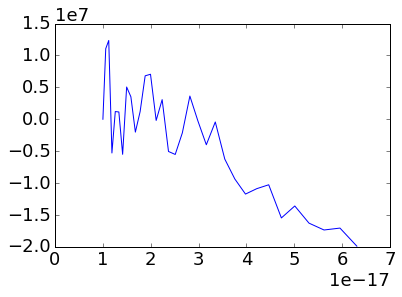

In [261]:
plt.plot(_fit_p,K)

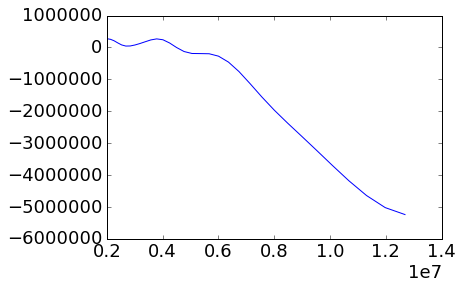

In [263]:
#plt.plot(alpha_1_sqr, 2.*np.pi*(fres_mask-fres_mask[0]))
plt.plot(alpha_1_sqr, gaussian_filter1d(2.*np.pi*(_fit_fr-_fit_fr[0]),2))

In [264]:
np.array(alpha_1_sqr).shape

(33,)

In [265]:
_fr_m[0]

7505583027.2490873

In [268]:
a, b = np.polyfit(np.array(alpha_1_sqr),gaussian_filter1d(2.*np.pi*(_fit_fr-_fit_fr[0]),2), 1)

In [277]:
a,b

(-0.53193344636816764, 2028277.1616489654)

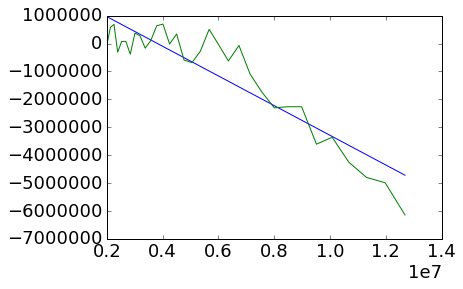

In [279]:
plt.plot(alpha_1_sqr, a*np.array(alpha_1_sqr)+b)
plt.plot(alpha_1_sqr, 2.*np.pi*(_fit_fr-_fit_fr[0]))

### participation ratio

In [280]:
alpha = a*(kappa+gamma)**2./(4.*kappa)
print alpha

-21625038.7431


In [514]:
alpha/(2.*np.pi*fr)*10**4

-4.5847443974374196

In [292]:
deltaf_alpha = 4*kappa*alpha*dBm2Watt(powerspec._power)/(2.*np.pi*(kappa+gamma)**2.*hbar*w0)

In [281]:
alpha_0 = np.pi**2.*np.pi*fres_mask[0]*50/R_k

In [282]:
gamma_0 = (np.abs(2*np.pi*alpha)/alpha_0)**(1/3.)
print gamma_0

0.670485385753


In [283]:
gamma_0eich = (-alpha*R_k*32./(np.pi**3.*2.*np.pi*fres_mask[0]*50.))**(1/3.)
print gamma_0eich

0.625152631153


In [581]:
gamma_0*cpw_res._L

8.3784465736255039e-10

In [580]:
gamma_0eich*cpw_res._L

7.811964334763698e-10

### critical current

In [588]:
Ic1 = phi_0/(2.*np.pi*gamma_0eich*cpw_res._L)
print Ic1

4.21284534329e-07


In [589]:
Ic2 = phi_0/(2.*np.pi*gamma_0eich*cpw_res._L)
print Ic2

4.21284534329e-07


In [591]:
cpw_res.fres_Wallraff(Ic1, Ic1, 0, 1)

7737813166.392807

In [662]:
alpha_crit = dBm2Watt(-121)/(hbar*w0)
print alpha_crit

159722471.387


In [666]:
K_crit = -(kappa+gamma)**3./(np.sqrt(27)*kappa*alpha_crit)
print K_crit

-23512056.2275


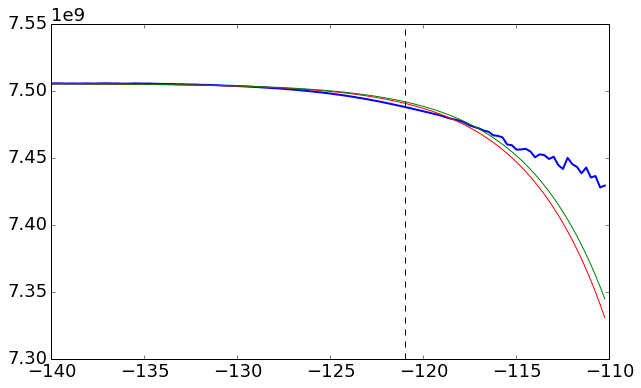

In [295]:
fig02 = plt.figure(figsize = (10,6))
plt.plot(powerspec._power, fres_mask, lw = 2.)
plt.plot(powerspec._power, fr+deltaf, color = 'red')
plt.plot(powerspec._power, fr+deltaf_alpha, color = 'green')
plt.axvline(-121, color = 'black', ls = '--')

(7450000000.0, 7510000000.0)

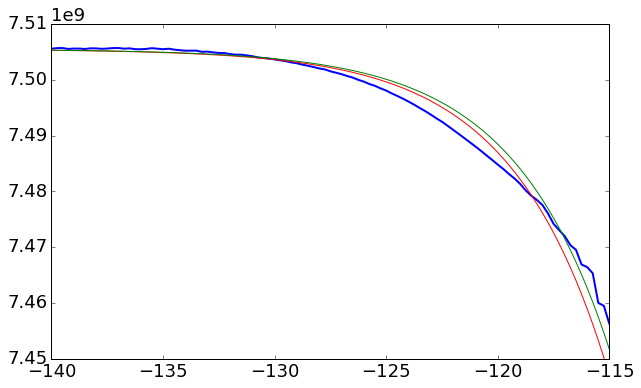

In [296]:
fig02 = plt.figure(figsize = (10,6))
plt.plot(powerspec._power, fres_mask, lw = 2.)
plt.plot(powerspec._power, fr+deltaf, color = 'red')
plt.plot(powerspec._power, fr+deltaf_alpha, color = 'green')
plt.xlim(-140,-115)
plt.ylim(7.45e9,7.51e9)

In [301]:
#number of photons inside cavity
def n1(delta,e1):
    '''delta: signal-pump detuning; e1: effective pump strength'''
    a = e1**2.
    b = -2.*delta*e1
    c = (delta**2.+1./4.)
    d = -1.
    DELTA = 18*a*b*c*d - 4*b**3.*d + (b*c)**2.-4*a*c**3. - 27*(a*d)**2.
    DELTA_0 = b**2. - 3*a*c
    DELTA_1 = 2*b**3.-9*a*b*c + 27*a**2.*d
    arg = np.array(-27.*a**2.*DELTA)
    results = np.sqrt(arg)
    C = ((DELTA_1+results)/2)**(1/3.)
    u1 = 1.
    n = np.array(-1/(3*a)*(b+u1*C+DELTA_0/(u1*C)))
    return n


In [357]:
# scale invariante squared input amplitude (Eichler)
alpha_in_sqr = dBm2Watt(powerspec._power)/(hbar*w0) 
_alpha_in_sqr = kappa*alpha_in_sqr/(kappa+gamma)**2.

In [358]:
delta = 2.*np.pi*(fres_mask-fres_mask[0])/(kappa+gamma)
zeta = _alpha_in_sqr*K/(kappa+gamma)

In [361]:
zeta.shape

(120,)

In [638]:
t = 0
n=[]
n_strich=[]
for i in delta:
    n.append(n1(i, zeta[t]))
    n_strich.append(n1(0, zeta[t]))
    t +=1
n = np.array(n)
n_strich = np.array(n_strich)

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars


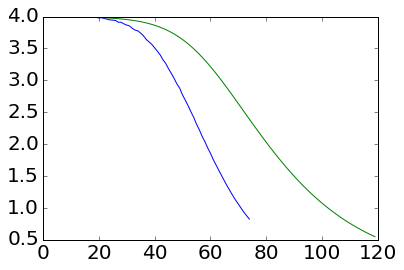

In [639]:
plt.plot(n)
plt.plot(n_strich)

In [654]:
t = 0
df=[]
for i in delta:
    if n1(i, zeta[t]) != None:
        df.append(alpha/5*4.*_alpha_in_sqr[t])
    t +=1

C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in double_scalars


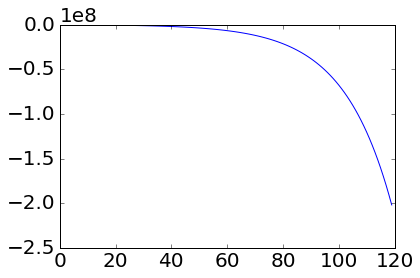

In [655]:
plt.plot(df)

In [656]:
np.array(df).shape

(120,)

(7450000000.0, 7510000000.0)

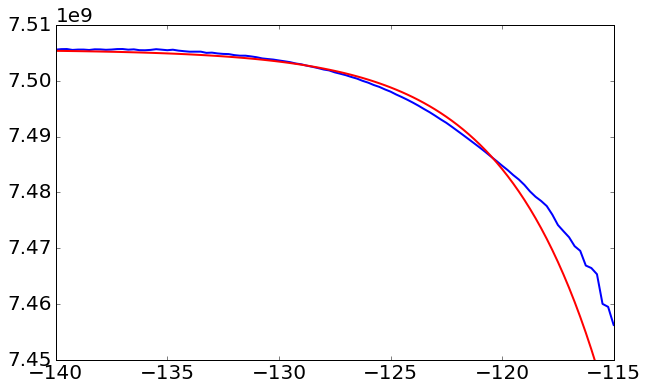

In [658]:
fig02 = plt.figure(figsize = (10,6))
plt.plot(powerspec._power, fres_mask, lw = 2.)
plt.plot(powerspec._power, _fit_fr[0]+df, lw = 2., color = 'red')
plt.xlim(-140,-115)
plt.ylim(7.45e9,7.51e9)

# critical frequency shift

In [503]:
np.where(powerspec._power == -122)

(array([72]),)

In [504]:
deltaf_crit = -np.sqrt(3)/2*(kappa+gamma)/(2.*np.pi)

In [505]:
print deltaf_crit/10**6.

-16.5397785779


In [509]:
(fres_mask[75]-fres_mask[0])/10**6

-16.791015109549523

# circle fit 

In [ ]:
i = 1

In [ ]:
z_data_raw.shape

In [ ]:
_fr, sign = cf._phase_fr_sign(fit_freq, np.unwrap(np.angle(z_data_raw[i])),3, 20)
_theta0, _Ql, _fr, _slope = cf._phase_fit_wslope(fit_freq, z_data_raw[i], -4, 400, _fr, 0, 1, overcoupled = True)

In [ ]:
_phase = np.unwrap(np.angle(z_data_raw[i]))
_phase_fit = cf.phase_fitfunction(fit_freq, _theta0, _Ql, _fr, _slope, 1., True )[0]
fig, axes = plt.subplots(figsize = (7,7))
axes.plot(fit_freq/10**9, _phase, label = 'data', lw = 2.)
axes.plot(fit_freq/10**9., _phase_fit,label = 'phase fit w/ slope', color = 'red', lw = 2.)
axes.axvline(_fr/10**9., color = 'red', ls = '-', lw = 2.)
axes.set_xlabel(r'$f_{\mu w}$', fontsize = labelsize)
axes.set_ylabel(r'$arg(S_{11})$', fontsize = labelsize)
#axes.set_xlim(8.83,8.85)
plt.setp(axes, yticks=[-np.pi,-np.pi/2, 0., np.pi/2., np.pi], yticklabels = [r'$-\pi$',r'$-\frac{\pi}{2}$', '0',  r'$\frac{\pi}{2}$', r'$\pi$'])
#axes.set_title(str(title), fontsize = 20.)
#axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
'''circle fit routine for every power value'''
fres_cal = []
fres_pf = []
chi_sqr = []
Qloaded = []
Qload_pf = []
z_data_sim = []
for i in range(len(power)):
#for i in range(10):
    #powerspec._get_data_circle(norm = False)
    cf = rf_p(fit_freq, z_data_raw[i])
    cf.set_Ql(400)
    cf.set_theta0(-4.0)
    cf.autofit(coupling = 'overcoupled', ignoreslope = False, refine_res = True, plot = False)
    z_data_sim.append(cf.z_data_sim)
    fitresults = cf.fitresults
    fres_cal.append(fitresults['fr'])
    chi_sqr.append(fitresults['chi_square'])
    Qloaded.append(fitresults['Ql'])
    
    _fr, sign = cf._phase_fr_sign(fit_freq, np.unwrap(np.angle(z_data_raw[i])),3, 20)
    theta0, Ql, fr = cf._phase_fit(fit_freq, z_data_raw[i], 0.1, 400, _fr, 1.)
    Qload_pf.append(Ql)
    fres_pf.append(fr)

In [ ]:
fig, axes = plt.subplots(figsize = (10,6))
axes.plot(power, Qloaded, label = r'$Q_L$ (circle fit)', lw = 2, color = 'blue')
axes.plot(power, Qload_pf, label = r'$Q_L$ (phase fit)', lw = 2, color = 'green')
axes.set_ylabel(r'$\mathrm{quality factor}\,\,Q_l$ [Hz]', fontsize = labelsize)
axes.set_xlabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize= labelsize)
axes.legend()

In [ ]:
fres_cal = np.array(fres_cal)
mask = []
for i in range(len(fres_cal)):
    low = 8.8e9
    high = 9.e9
    mask.append(np.any((fres_cal[i] > high, fres_cal[i] < low), axis = 0))

In [ ]:
fres_mask = np.ma.masked_array(fres_cal,mask)

In [ ]:
fig, axes = plt.subplots(figsize = (10,6))
axes.plot(fres_mask, label = 'fres (circle fit)', lw = 2, color = 'blue')
axes.plot(fres_pf, label = 'fres (phase fit)', lw = 2, color = 'green')
axes.set_ylabel(r'$\mathrm{res.\,freq.} f$ [Hz]', fontsize = labelsize)
axes.set_xlabel(r'$f_{\mu w}\,(\mathrm{Hz})$', fontsize= labelsize)

In [ ]:
n_ph = cf.get_photons_in_resonator(powerspec._power)

In [ ]:
fig, axes = plt.subplots(figsize = (15,6))
axes.plot(n_ph,(fres_mask-fres_mask[0])/1000, label = r'data', lw = 4)

axes.set_ylabel(r'$\mathrm{freq.\,shift}\,\,\delta f$ [kHz]', fontsize = labelsize)
axes.set_xlabel(r'$\mathrm{number\,\,of\,\,photons}\,\,n = |A|^2 $', fontsize = labelsize)
axes.legend()

In [ ]:
a, b, c, d = np.polyfit((n_ph-n_ph[0]),fres_mask-fres_mask[0], 3)

In [ ]:
gamma_0 = (np.abs(2*np.pi*c)/alpha_0)**(1/3.)
print gamma_0

In [ ]:
L_s = gamma_0 * cpw_res._L
print L_s, cpw_res._L

In [ ]:
I_c = (2*np.pi*(L_s)/phi_0)**(-1)/2
print I_c

In [ ]:
fig, axes = plt.subplots(figsize = (15,6))
axes.plot(n_ph,(fres_mask-fres_mask[0])/1000, label = r'data', lw = 4)
axes.plot(n_ph, (a*(n_ph-n_ph[0])**3.+b*(n_ph-n_ph[0])**2.+c*(n_ph-n_ph[0])+d)/1000, label = r'fit', lw = 3, color = 'red')
#axes.axvline(n[0])
axes.set_ylabel(r'$\mathrm{freq.\,shift}\,\,\delta f$ [kHz]', fontsize = labelsize)
axes.set_xlabel(r'$\mathrm{number\,\,of\,\,photons}\,\,n = |A|^2 $', fontsize = labelsize)
#axes.set_xlim(0,1000)
#axes.set_ylim(-2000,0)
axes.axvline(n_ph[0], color = 'black', ls = '-.', lw = 2)
axes.legend()

In [ ]:
fig, axes = plt.subplots(figsize = (10,6))
axes.plot(powerspec._power, chi_sqr, lw = 2)
axes.set_ylabel(r'$\chi^2$', fontsize = labelsize)
axes.set_xlabel(r'$P_{\mu w}\,(\mathrm{dBm})$', fontsize= labelsize)

In [ ]:
powerspec.plot(powerspec._power,powerspec._freq,powerspec._phase_spec,fres_mask)

In [ ]:
powerspec.plot(powerspec._power,powerspec._freq,powerspec._amp_n,fres_mask)

In [ ]:
for i in range(len(powerspec._power)):
    fig, axes = plt.subplots(figsize = (9,4))
    #axes.plot(powerspec._freq, powerspec._phase_n.T[i], lw = 2)
    axes.plot(powerspec._freq, data['/entry/data0/phase'][i])
    axes.plot(powerspec._freq, np.angle(z_data_sim[i]), lw = 2, color = 'red')

In [ ]:
fig, axes = plt.subplots(2,1, figsize = (16,10))
xticks = np.arange(8.82e9, 8.87e9, 1e7)
for i in range(len(powerspec._power)):
    axes[0].plot(powerspec._freq, np.angle(powerspec._z_data_raw[i]))
    axes[0].set_ylabel(r'$arg(S11)$ [rad]', fontsize = labelsize)
    axes[0].set_xticks(xticks)
    axes[1].plot(powerspec._freq, np.absolute(powerspec._z_data_raw[i]))
    axes[1].set_xlabel(r'frequency $f$ [Hz]', fontsize = labelsize)
    axes[1].set_ylabel(r'$|S11|$ [a. u.]', fontsize = labelsize)
    axes[1].set_xticks(xticks)

## duffing non-linearity alpha & participation ratio

In [ ]:
a, b, c, d = np.polyfit((n-n[0]),fres_mask_lowP-fres_mask_lowP[0], 3)
print c

In [ ]:
gamma_0 = (np.abs(2*np.pi*c)/alpha_0)**(1/3.)
print gamma_0

In [ ]:
L_s = gamma_0 * cpw_res._L
print 'LJ = {} H, L_res = {}'.format(L_s, cpw_res._L)

In [ ]:
I_c = (2*np.pi*(L_s)/phi_0)**(-1)/2
print I_c

In [ ]:
aa, ba, ca, da = np.polyfit((n-n[0]),fres_pf_lowP-fres_pf_lowP[0], 3)
print ca

In [ ]:
gamma_0a = (np.abs(2*np.pi*ca)/alpha_0)**(1/3.)
print gamma_0a

In [ ]:
L_sa = gamma_0a * cpw_res._L
print L_sa, cpw_res._L

In [ ]:
I_ca = (2*np.pi*(L_sa)/phi_0)**(-1)/2
print I_ca

In [ ]:
fig, axes = plt.subplots(figsize = (15,6))
axes.plot(n,(fres_pf_lowP-fres_pf_lowP[0])/1000, label = r'data (phase fit)', lw = 4)
axes.plot(n, (aa*(n-n[0])**3.+ba*(n-n[0])**2.+ca*(n-n[0])+da)/1000, label = r'fit', lw = 3, color = 'red')
#axes.axvline(n[0])
axes.set_ylabel(r'$\mathrm{freq.\,shift}\,\,\delta f$ [kHz]', fontsize = labelsize)
axes.set_xlabel(r'$\mathrm{number\,\,of\,\,photons}\,\,n = |A|^2 $', fontsize = labelsize)
axes.axvline(n[0], color = 'black', ls = '-.', lw = 2)
axes.legend()

In [ ]:
fig, axes = plt.subplots(figsize = (15,6))
axes.plot(n,(fres_mask_lowP-fres_mask_lowP[0])/1000, label = r'data (circle fit)', lw = 4)
axes.plot(n, (a*(n-n[0])**3.+b*(n-n[0])**2.+c*(n-n[0])+d)/1000, label = r'fit', lw = 3, color = 'red')
#axes.axvline(n[0])
axes.set_ylabel(r'$\mathrm{freq.\,shift}\,\,\delta f$ [kHz]', fontsize = labelsize)
axes.set_xlabel(r'$\mathrm{number\,\,of\,\,photons}\,\,n = |A|^2 $', fontsize = labelsize)
axes.axvline(n[0], color = 'black', ls = '-.', lw = 2)
axes.legend()

In [ ]:
fig, axes = plt.subplots(figsize = (10,6))
axes.plot(power_lowP, chi_sqr_lowP, lw = 2)
axes.set_ylabel(r'$\chi^2$', fontsize = labelsize)
axes.set_xlabel(r'$P_{\mu w}\,(\mathrm{dBm})$', fontsize= labelsize)

In [ ]:
res_data_lowP.plot(power_lowP,res_data_lowP._freq,res_data_lowP._phase_spec_n,fres_mask_lowP)

In [ ]:
res_data_lowP.plot(power_lowP,res_data_lowP._freq,res_data_lowP._amp_spec,fres_mask_lowP)

In [ ]:
res_data_lowP.plot(power_lowP,res_data_lowP._freq,res_data_lowP._amp_spec_n,fres_mask_lowP)

In [ ]:
fig, axes = plt.subplots(2,1, figsize = (16,10))
for i in range(len(power_lowP)):
        axes[0].plot(f_data_lowP, np.angle(z_data_raw_lowP[i]))
        axes[1].plot(f_data_lowP, np.absolute(z_data_raw_lowP[i]))